<a href="https://colab.research.google.com/github/mahault/Drone-governance/blob/main/Drone_governance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

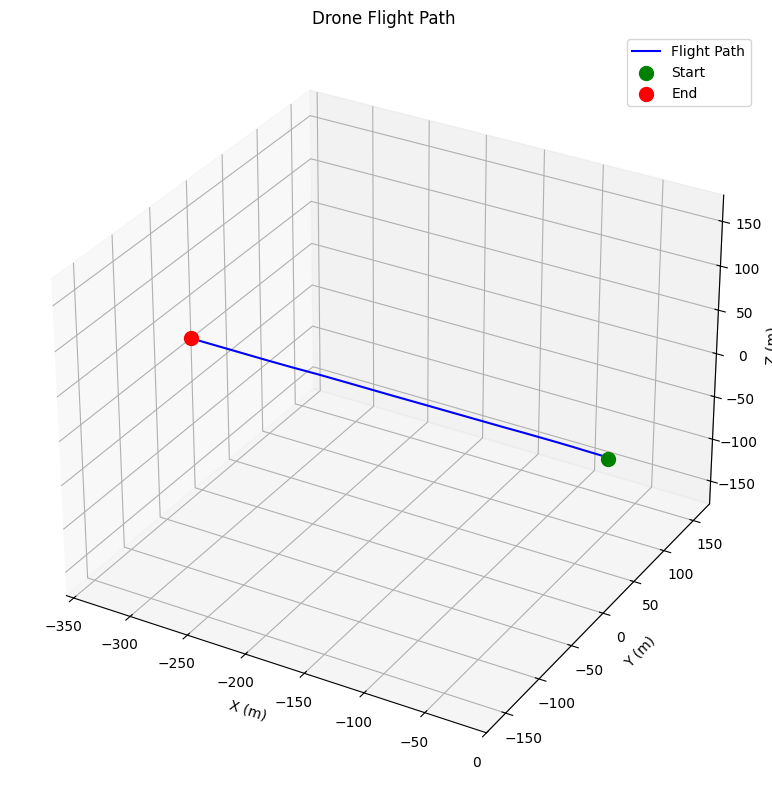

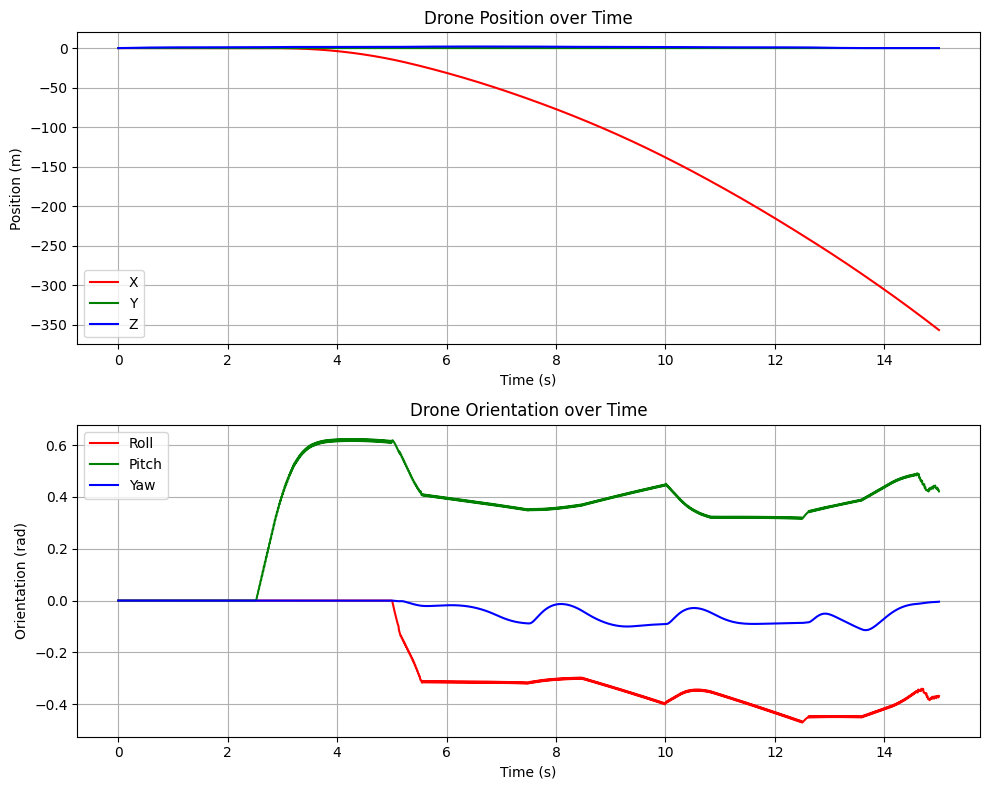

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

class DroneModel:
    def __init__(self):
        # Drone physical parameters
        self.mass = 1.0  # kg
        self.gravity = 9.81  # m/s^2
        self.I = np.array([0.01, 0.01, 0.02])  # Inertia moments (kg*m^2)
        self.arm_length = 0.2  # m

        # State variables
        self.position = np.zeros(3)  # [x, y, z] in m
        self.velocity = np.zeros(3)  # [vx, vy, vz] in m/s
        self.orientation = np.zeros(3)  # [roll, pitch, yaw] in radians
        self.angular_velocity = np.zeros(3)  # [wx, wy, wz] in rad/s

        # Control inputs (normalized between 0 and 1)
        self.motor_speeds = np.array([0.0, 0.0, 0.0, 0.0])

        # Simulation parameters
        self.dt = 0.01  # time step for integration

        # Motor constants
        self.thrust_coefficient = 5.0  # N/unit
        self.torque_coefficient = 0.05  # Nm/unit

        # History for plotting
        self.history = {
            'position': [self.position.copy()],
            'orientation': [self.orientation.copy()],
            'time': [0.0]
        }
        self.current_time = 0.0

    def update(self, motor_speeds):
        """Update drone state based on motor inputs."""
        self.motor_speeds = np.clip(motor_speeds, 0.0, 1.0)

        # Calculate total thrust and torques
        thrust = self.thrust_coefficient * np.sum(self.motor_speeds)

        # Torque calculation (simplified model)
        # For a quadcopter in X configuration
        # Motors 0 and 2 rotate CW, Motors 1 and 3 rotate CCW
        roll_torque = self.arm_length * self.thrust_coefficient * (
            self.motor_speeds[1] + self.motor_speeds[2] -
            self.motor_speeds[0] - self.motor_speeds[3]
        )

        pitch_torque = self.arm_length * self.thrust_coefficient * (
            self.motor_speeds[0] + self.motor_speeds[1] -
            self.motor_speeds[2] - self.motor_speeds[3]
        )

        yaw_torque = self.torque_coefficient * (
            -self.motor_speeds[0] + self.motor_speeds[1] -
            self.motor_speeds[2] + self.motor_speeds[3]
        )

        torques = np.array([roll_torque, pitch_torque, yaw_torque])

        # Calculate acceleration
        # Rotation matrix (simplified)
        cos_roll, sin_roll = np.cos(self.orientation[0]), np.sin(self.orientation[0])
        cos_pitch, sin_pitch = np.cos(self.orientation[1]), np.sin(self.orientation[1])

        R = np.array([
            [cos_pitch, 0, -sin_pitch],
            [0, cos_roll, 0],
            [sin_pitch, 0, cos_pitch]
        ])

        # Force in global frame
        force_body = np.array([0, 0, thrust])
        force_global = R @ force_body

        # Acceleration = Force/mass + gravity
        acceleration = force_global / self.mass
        acceleration[2] -= self.gravity  # Gravity acts in negative z

        # Update position and velocity
        self.velocity += acceleration * self.dt
        self.position += self.velocity * self.dt

        # Prevent drone from going underground
        if self.position[2] < 0:
            self.position[2] = 0
            self.velocity[2] = 0

        # Update angular velocity and orientation
        angular_acceleration = torques / self.I
        self.angular_velocity += angular_acceleration * self.dt
        self.orientation += self.angular_velocity * self.dt

        # Normalize angles to [-pi, pi]
        self.orientation = np.mod(self.orientation + np.pi, 2 * np.pi) - np.pi

        # Update time and history
        self.current_time += self.dt
        self.history['position'].append(self.position.copy())
        self.history['orientation'].append(self.orientation.copy())
        self.history['time'].append(self.current_time)


class PIDController:
    def __init__(self, kp, ki, kd, output_limits=None):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.output_limits = output_limits

        self.integral = 0
        self.previous_error = 0
        self.first_run = True

    def update(self, error, dt):
        # Initialize previous error on first run
        if self.first_run:
            self.previous_error = error
            self.first_run = False

        # Proportional term
        p_term = self.kp * error

        # Integral term
        self.integral += error * dt
        i_term = self.ki * self.integral

        # Derivative term
        d_term = self.kd * (error - self.previous_error) / dt
        self.previous_error = error

        # Calculate output
        output = p_term + i_term + d_term

        # Apply limits if specified
        if self.output_limits is not None:
            output = np.clip(output, *self.output_limits)

        return output


class DroneController:
    def __init__(self, drone_model):
        self.drone = drone_model

        # PID controllers for position
        self.pid_x = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
        self.pid_y = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
        self.pid_z = PIDController(2.0, 0.1, 1.0, output_limits=(-1.0, 1.0))

        # PID controllers for angles
        self.pid_roll = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
        self.pid_pitch = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
        self.pid_yaw = PIDController(3.0, 0.0, 1.0, output_limits=(-0.3, 0.3))

        # Target positions and orientations
        self.target_position = np.zeros(3)
        self.target_yaw = 0.0

    def set_target(self, position, yaw=0.0):
        """Set target position and yaw orientation."""
        self.target_position = np.array(position)
        self.target_yaw = yaw

    def update(self):
        """Calculate control inputs based on current state and targets."""
        # Position errors
        pos_error = self.target_position - self.drone.position

        # Desired roll and pitch based on position error
        desired_pitch = self.pid_x.update(pos_error[0], self.drone.dt)
        desired_roll = -self.pid_y.update(pos_error[1], self.drone.dt)  # Negative for correct mapping

        # Altitude control
        z_thrust = 0.5 + self.pid_z.update(pos_error[2], self.drone.dt)  # Base thrust plus correction

        # Angle errors
        roll_error = desired_roll - self.drone.orientation[0]
        pitch_error = desired_pitch - self.drone.orientation[1]
        yaw_error = self.target_yaw - self.drone.orientation[2]

        # Normalize yaw error to [-pi, pi]
        yaw_error = np.mod(yaw_error + np.pi, 2 * np.pi) - np.pi

        # Calculate torque corrections
        roll_correction = self.pid_roll.update(roll_error, self.drone.dt)
        pitch_correction = self.pid_pitch.update(pitch_error, self.drone.dt)
        yaw_correction = self.pid_yaw.update(yaw_error, self.drone.dt)

        # Calculate motor speeds
        # For a quadcopter in X configuration:
        # m0: front-right, m1: front-left, m2: back-left, m3: back-right
        m0 = z_thrust - roll_correction + pitch_correction - yaw_correction
        m1 = z_thrust + roll_correction + pitch_correction + yaw_correction
        m2 = z_thrust + roll_correction - pitch_correction - yaw_correction
        m3 = z_thrust - roll_correction - pitch_correction + yaw_correction

        # Ensure motor values are within limits
        motor_speeds = np.clip(np.array([m0, m1, m2, m3]), 0.0, 1.0)

        return motor_speeds


def simulate_drone_flight(waypoints, flight_duration):
    """Simulate drone flying through a set of waypoints."""
    # Create drone and controller
    drone = DroneModel()
    controller = DroneController(drone)

    # Set initial position
    drone.position = np.array([0.0, 0.0, 0.0])

    # Simulation time steps
    total_steps = int(flight_duration / drone.dt)
    waypoint_index = 0
    steps_per_waypoint = total_steps // len(waypoints)

    # Main simulation loop
    for step in range(total_steps):
        # Update target waypoint if needed
        if step % steps_per_waypoint == 0 and waypoint_index < len(waypoints):
            controller.set_target(waypoints[waypoint_index])
            waypoint_index = min(waypoint_index + 1, len(waypoints) - 1)

        # Calculate control inputs
        motor_speeds = controller.update()

        # Update drone state
        drone.update(motor_speeds)

    return drone


def visualize_flight(drone):
    """Create a 3D visualization of the drone flight path."""
    positions = np.array(drone.history['position'])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot flight path
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', label='Flight Path')

    # Mark start and end points
    ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], c='g', marker='o', s=100, label='Start')
    ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], c='r', marker='o', s=100, label='End')

    # Set labels and limits
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')

    # Equal aspect ratio
    max_range = np.array([
        positions[:, 0].max() - positions[:, 0].min(),
        positions[:, 1].max() - positions[:, 1].min(),
        positions[:, 2].max() - positions[:, 2].min()
    ]).max() / 2.0

    mid_x = (positions[:, 0].max() + positions[:, 0].min()) * 0.5
    mid_y = (positions[:, 1].max() + positions[:, 1].min()) * 0.5
    mid_z = (positions[:, 2].max() + positions[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.legend()
    plt.title('Drone Flight Path')
    plt.tight_layout()

    return fig


# Example usage
def run_example():
    # Define waypoints for the drone to follow (x, y, z) in meters
    waypoints = [
        [0.0, 0.0, 1.0],    # Take off to 1m
        [1.0, 0.0, 1.5],    # Move forward and up slightly
        [1.0, 1.0, 2.0],    # Move right and up
        [0.0, 1.0, 1.5],    # Move backward
        [0.0, 0.0, 1.0],    # Return to start position
        [0.0, 0.0, 0.0]     # Land
    ]

    # Simulate drone flight
    drone = simulate_drone_flight(waypoints, flight_duration=15.0)

    # Visualize the flight
    fig = visualize_flight(drone)
    plt.show()

    # Plot position and orientation over time
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Position plot
    positions = np.array(drone.history['position'])
    time = drone.history['time']
    ax1.plot(time, positions[:, 0], 'r-', label='X')
    ax1.plot(time, positions[:, 1], 'g-', label='Y')
    ax1.plot(time, positions[:, 2], 'b-', label='Z')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (m)')
    ax1.legend()
    ax1.set_title('Drone Position over Time')
    ax1.grid(True)

    # Orientation plot
    orientations = np.array(drone.history['orientation'])
    ax2.plot(time, orientations[:, 0], 'r-', label='Roll')
    ax2.plot(time, orientations[:, 1], 'g-', label='Pitch')
    ax2.plot(time, orientations[:, 2], 'b-', label='Yaw')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Orientation (rad)')
    ax2.legend()
    ax2.set_title('Drone Orientation over Time')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_example()

Running active inference simulation with three stages...

=== Stage 1: No uncertainty, No preference ===
Trial 1 (Stage 1: No uncertainty, No preference)
  Position: 7
  Context: 2 (Red)
  Condition: 2 (Emergency)
  Actuator: 1 (ON)
Trial 2 (Stage 1: No uncertainty, No preference)
  Position: 2
  Context: 2 (Red)
  Condition: 1 (Normal)
  Actuator: 1 (ON)
Trial 3 (Stage 1: No uncertainty, No preference)
  Position: 5
  Context: 1 (Green)
  Condition: 2 (Emergency)
  Actuator: 1 (ON)
Trial 4 (Stage 1: No uncertainty, No preference)
  Position: 1
  Context: 1 (Green)
  Condition: 1 (Normal)
  Actuator: 1 (ON)
Trial 5 (Stage 1: No uncertainty, No preference)
  Position: 5
  Context: 2 (Red)
  Condition: 2 (Emergency)
  Actuator: 1 (ON)
Trial 6 (Stage 1: No uncertainty, No preference)
  Position: 8
  Context: 2 (Red)
  Condition: 1 (Normal)
  Actuator: 1 (ON)
Trial 7 (Stage 1: No uncertainty, No preference)
  Position: 2
  Context: 1 (Green)
  Condition: 2 (Emergency)
  Actuator: 1 (ON)
Tr

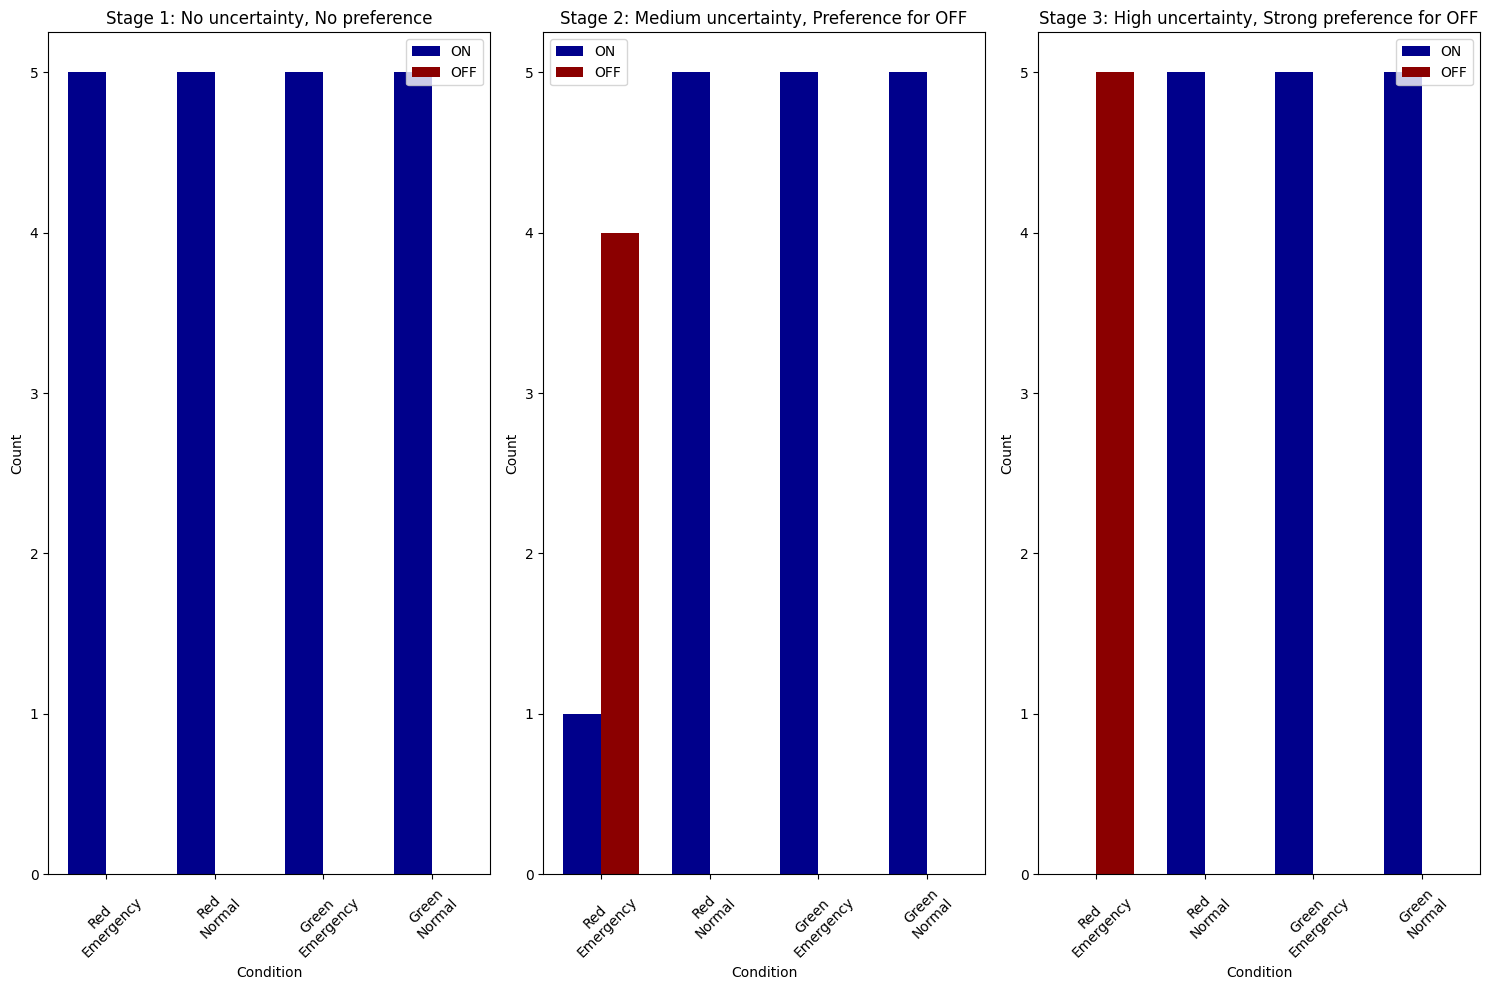

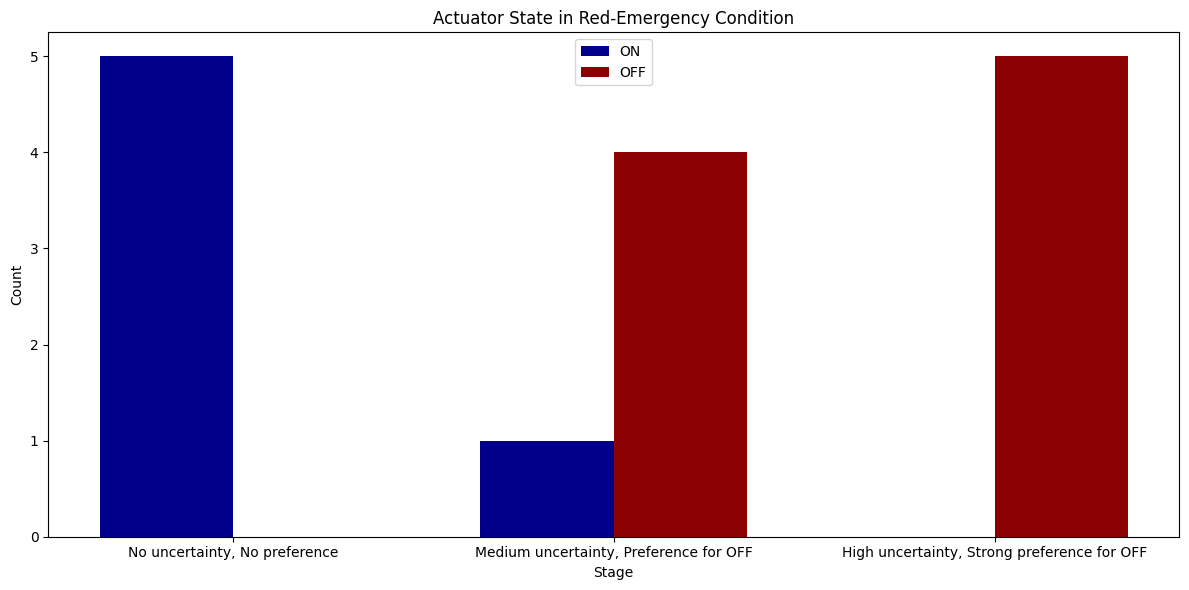

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

def setup_active_inference_model():
    """
    Set up the Active Inference model for the drone.
    This translates the MATLAB code provided to Python.
    """
    # Set random seed for reproducibility
    np.random.seed(None)  # Similar to rng('shuffle')

    # Model specification
    # Prior beliefs about initial states (D)
    D = {}
    D[1] = np.array([[1, 0, 0, 0, 0, 0, 0, 0]]).T  # XYZ position
    D[2] = np.array([[1, 0]]).T  # Green/Red
    D[3] = np.array([[1, 0]]).T  # Normal/Emergency

    # Likelihood mapping (A)
    A = {}

    # A1 modalities (actuator state)
    A[1] = np.zeros((2, 8, 2, 2))  # (output states, hidden states, context, conditions)

    # Normal context (1), Normal condition (1)
    A[1][:, :, 0, 0] = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],  # actuator on
        [0, 0, 0, 0, 0, 0, 0, 0]   # actuator off
    ])

    # Red context (2), Normal condition (1)
    A[1][:, :, 1, 0] = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],  # actuator on
        [0, 0, 0, 0, 0, 0, 0, 0]   # actuator off
    ])

    # Normal context (1), Emergency condition (2)
    A[1][:, :, 0, 1] = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],  # actuator on
        [0, 0, 0, 0, 0, 0, 0, 0]   # actuator off
    ])

    # Red context (2), Emergency condition (2)
    a = 1  # This will be adjusted for uncertainty
    b = 1 - a
    A[1][:, :, 1, 1] = np.array([
        [a, a, a, a, a, a, a, a],  # actuator on
        [b, b, b, b, b, b, b, b]   # actuator off
    ])

    # A2 modalities (XYZ position)
    A[2] = np.zeros((8, 8, 2, 2))
    for ctx in range(2):
        for cond in range(2):
            A[2][:, :, ctx, cond] = np.eye(8)

    # Transition probabilities (B)
    B = {}

    # B1: XYZ transitions
    B[1] = np.zeros((8, 8, 8))
    for i in range(8):
        Ber = np.zeros((8, 8))
        Ber[i, :] = 1
        B[1][:, :, i] = Ber

    # B2: Green/Red transitions
    B[2] = np.zeros((2, 2, 1))
    B[2][:, :, 0] = np.eye(2)

    # B3: Normal/Emergency transitions
    B[3] = np.zeros((2, 2, 1))
    B[3][:, :, 0] = np.eye(2)

    # Preference for states (C)
    C = {}
    # Default preferences - neutral
    C[1] = np.zeros((2, 2))  # No preference for actuator state by default

    # Actions/policies (U)
    U = np.zeros((1, 8, 3))
    U[0, :, 0] = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # XYZ positions
    for i in range(8):
        U[0, i, 1] = 1  # Context
        U[0, i, 2] = 1  # Conditions

    # MDP structure
    mdp = {
        'T': 2,          # Time steps
        'U': U,          # Policies/actions
        'A': A,          # Observation model (likelihood)
        'B': B,          # Transition probabilities
        'D': D,          # Prior beliefs about initial states
        'C': C,          # Preferences
    }

    return mdp

def spm_softmax(x):
    """Simple softmax function"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def spm_MDP_VB_X(mdp):
    """
    A simplified Python implementation of the SPM's active inference for MDPs.
    This implements only the essentials for state estimation and action selection.
    """
    # Extract dimensions
    T = mdp.get('T', 1)                # Number of time steps
    V = len(mdp.get('A', {}))          # Number of outcome modalities

    # Initialize state, outcomes and actions
    s = mdp.get('s', {}).copy()        # Initial states (copy to avoid modifying original)
    o = {}                             # Outcomes
    u = np.zeros((T-1, 1), dtype=int)  # Actions

    # Make sure states are properly initialized for all time steps
    for factor in range(len(mdp['B'])):
        factor_key = factor + 1
        if factor_key in s:
            # If state array is not properly shaped for all timesteps, reshape it
            if s[factor_key].shape[0] < T:
                # Get initial state
                init_state = s[factor_key][0].copy()
                # Create new array with correct time dimension
                s[factor_key] = np.zeros((T, 1), dtype=int)
                # Set initial state
                s[factor_key][0, 0] = init_state[0]

    # Initialize Q distributions (posterior beliefs about states)
    Q = {}
    for f in range(len(mdp['B'])):
        factor_key = f + 1
        Q[factor_key] = np.ones((mdp['B'][factor_key].shape[0], T)) / mdp['B'][factor_key].shape[0]
        # Set prior as initial posterior for first timestep if available
        if factor_key in mdp['D']:
            Q[factor_key][:, 0] = mdp['D'][factor_key].flatten()

    # For each time step
    for t in range(T):
        # Generate outcomes from states for this timestep
        for modality in range(V):
            modality_key = modality + 1

            # Initialize outcome array if not already done
            if modality_key not in o:
                o[modality_key] = np.zeros((T, 1), dtype=int)

            # Get states for each factor at this timestep
            state_indices = []
            for f in range(len(mdp['B'])):
                factor_key = f + 1
                if factor_key in s:
                    state_idx = int(s[factor_key][t, 0]) - 1  # Convert to 0-indexed
                    state_indices.append(state_idx)

            # If we have all needed factors, generate outcome
            if len(state_indices) >= 3:  # XYZ, context, condition
                # Get likelihood for this combination of states
                A_matrix = mdp['A'][modality_key]
                likelihood = A_matrix[:, state_indices[0], state_indices[1], state_indices[2]]

                # Sample outcome from the likelihood distribution
                # For deterministic policies, use argmax; for stochastic, sample
                if np.max(likelihood) == 1:  # Deterministic
                    o[modality_key][t, 0] = np.argmax(likelihood) + 1  # Convert to 1-indexed
                else:  # Stochastic
                    norm_likelihood = likelihood / np.sum(likelihood)
                    o[modality_key][t, 0] = np.random.choice(len(likelihood), p=norm_likelihood) + 1

        # If not the last timestep, select an action
        if t < T-1:
            # For simplicity, just keep the current states for the next timestep
            # In a full model, this would involve action selection based on expected free energy
            for f in range(len(mdp['B'])):
                factor_key = f + 1
                if factor_key in s:
                    s[factor_key][t+1, 0] = s[factor_key][t, 0]

            # Choose a random action for simplicity
            # In a real active inference model, this would be based on expected free energy
            u[t, 0] = np.random.randint(1, 9)  # 8 possible positions

    # Return results
    results = {
        's': s,  # Hidden states
        'o': o,  # Observations
        'u': u,  # Actions
        'Q': Q,  # Posterior expectations
    }

    return results

def enhanced_active_inference_model(uncertainty_level=0, add_preference=False, strong_preference=False):
    """
    Set up an active inference model with adjustable uncertainty
    and preference parameters.

    Parameters:
    uncertainty_level : float between 0 and 1
        Level of uncertainty in the actuator state in emergency conditions
    add_preference : bool
        Whether to add a preference for the OFF state in emergency conditions
    strong_preference : bool
        Whether to make the preference stronger (applies only if add_preference=True)
    """
    # Basic model setup
    mdp = setup_active_inference_model()

    # Adjust uncertainty in emergency conditions for Red context
    a = 1 - uncertainty_level  # Probability for actuator ON
    b = uncertainty_level     # Probability for actuator OFF

    # Update A matrix for emergency condition with uncertainty
    # This is RED context (1), Emergency condition (1)
    mdp['A'][1][:, :, 1, 1] = np.array([
        [a, a, a, a, a, a, a, a],  # actuator on probability
        [b, b, b, b, b, b, b, b]   # actuator off probability
    ])

    # Add preferences (C) if needed
    if add_preference:
        # Preference for actuator state
        if strong_preference:
            # Strong preference for OFF in emergency
            mdp['C'][1] = np.array([
                [0, -2],  # actuator on (negative preference in emergency)
                [0, 2]    # actuator off (strong preference in emergency)
            ])
        else:
            # Moderate preference for OFF in emergency
            mdp['C'][1] = np.array([
                [0, 0],  # actuator on (neutral)
                [0, 1]   # actuator off (preferred in emergency)
            ])

        # Prefer first location in normal condition
        mdp['C'][2] = np.zeros((8, 2))
        mdp['C'][2][0, 0] = 1  # Prefer first location in normal condition

    return mdp

def test_active_inference_models():
    """
    Test different active inference models with various uncertainty
    and preference settings.
    """
    # List to hold all trial results
    all_results = []

    # Define test configurations
    configs = [
        {"name": "No uncertainty, No preference", "uncertainty": 0.0, "preference": False},
        {"name": "Medium uncertainty, No preference", "uncertainty": 0.5, "preference": False},
        {"name": "Medium uncertainty, With preference", "uncertainty": 0.5, "preference": True},
        {"name": "High uncertainty, With preference", "uncertainty": 0.8, "preference": True},
    ]

    # Define states
    states = {
        "Green-Normal": {"context": 1, "condition": 1},
        "Green-Emergency": {"context": 1, "condition": 2},
        "Red-Normal": {"context": 2, "condition": 1},
        "Red-Emergency": {"context": 2, "condition": 2},
    }

    # Run tests for each configuration
    for config in configs:
        print(f"\nTesting: {config['name']}")

        # Create model with this configuration
        mdp = enhanced_active_inference_model(
            uncertainty_level=config["uncertainty"],
            add_preference=config["preference"]
        )

        # Test each state
        for state_name, state_values in states.items():
            print(f"  State: {state_name}")

            # Set up initial state
            mdp['s'] = {}
            mdp['s'][1] = np.array([[1]])  # Position 1
            mdp['s'][2] = np.array([[state_values["context"]]])  # Context
            mdp['s'][3] = np.array([[state_values["condition"]]])  # Condition

            # Run model
            result = spm_MDP_VB_X(mdp)

            # Record outcomes
            actuator_state = "ON" if result['o'][1][1, 0] == 1 else "OFF"
            print(f"    Actuator: {actuator_state}")

            # Store result
            result_entry = {
                "config": config["name"],
                "state": state_name,
                "context": state_values["context"],
                "condition": state_values["condition"],
                "actuator": result['o'][1][1, 0],
                "actuator_label": actuator_state
            }
            all_results.append(result_entry)

    return all_results

def run_realistic_scenario():
    """
    Run a more realistic scenario with three stages:
    1. No uncertainty, no preference
    2. Medium uncertainty, preference for OFF
    3. High uncertainty, strong preference for OFF

    Each stage has 10 trials with varied contexts and conditions
    """
    # Stage configurations
    stages = [
        {"name": "Stage 1: No uncertainty, No preference",
         "uncertainty": 0.0, "preference": False, "strong": False},
        {"name": "Stage 2: Medium uncertainty, Preference for OFF",
         "uncertainty": 0.5, "preference": True, "strong": False},
        {"name": "Stage 3: High uncertainty, Strong preference for OFF",
         "uncertainty": 0.8, "preference": True, "strong": True},
    ]

    trials_per_stage = 20
    all_results = []

    print("Running active inference simulation with three stages...")

    trial_count = 0

    # Run trials for each stage
    for stage_idx, stage in enumerate(stages):
        print(f"\n=== {stage['name']} ===")

        # Create model for this stage
        mdp = enhanced_active_inference_model(
            uncertainty_level=stage["uncertainty"],
            add_preference=stage["preference"],
            strong_preference=stage["strong"]
        )

        # Run trials for this stage
        for trial in range(trials_per_stage):
            trial_count += 1

            # Alternate between normal and emergency conditions
            # Ensure we get a good mix for testing
            if trial % 4 == 0:  # Every 4th trial
                context = 2  # Red
                condition = 2  # Emergency
                label = "Red-Emergency"
            elif trial % 4 == 1:
                context = 2  # Red
                condition = 1  # Normal
                label = "Red-Normal"
            elif trial % 4 == 2:
                context = 1  # Green
                condition = 2  # Emergency
                label = "Green-Emergency"
            else:
                context = 1  # Green
                condition = 1  # Normal
                label = "Green-Normal"

            # Random position
            position = np.random.randint(1, 9)

            # Set up initial state
            mdp['s'] = {}
            mdp['s'][1] = np.array([[position]])  # Position
            mdp['s'][2] = np.array([[context]])   # Context
            mdp['s'][3] = np.array([[condition]]) # Condition

            # Run model
            result = spm_MDP_VB_X(mdp)

            # Record outcome
            if 1 in result['o']:
                actuator = result['o'][1][1, 0]
                actuator_label = "ON" if actuator == 1 else "OFF"
            else:
                actuator = None
                actuator_label = "N/A"

            # Print results
            print(f"Trial {trial_count} ({stage['name']})")
            print(f"  Position: {position}")
            print(f"  Context: {context} ({'Red' if context == 2 else 'Green'})")
            print(f"  Condition: {condition} ({'Emergency' if condition == 2 else 'Normal'})")
            print(f"  Actuator: {actuator} ({actuator_label})")

            # Store result
            result_entry = {
                "trial": trial_count,
                "stage": stage_idx + 1,
                "stage_name": stage["name"],
                "position": position,
                "context": context,
                "condition": condition,
                "state_label": label,
                "actuator": actuator,
                "actuator_label": actuator_label
            }
            all_results.append(result_entry)

    return all_results

def analyze_scenario_results(results):
    """
    Analyze and plot the results from the scenario simulation.
    """
    # Organize results by stage and condition
    stages = {}

    for result in results:
        stage = result["stage"]
        if stage not in stages:
            stages[stage] = {
                "name": result["stage_name"],
                "Green-Normal": {"ON": 0, "OFF": 0},
                "Green-Emergency": {"ON": 0, "OFF": 0},
                "Red-Normal": {"ON": 0, "OFF": 0},
                "Red-Emergency": {"ON": 0, "OFF": 0}
            }

        # Increment count for this condition and actuator state
        label = result["state_label"]
        if result["actuator_label"] == "ON":
            stages[stage][label]["ON"] += 1
        elif result["actuator_label"] == "OFF":
            stages[stage][label]["OFF"] += 1

    # Print summary statistics
    print("\nResults Summary:")

    for stage, data in stages.items():
        print(f"\n=== {data['name']} ===")

        for condition in ["Green-Normal", "Green-Emergency", "Red-Normal", "Red-Emergency"]:
            total = data[condition]["ON"] + data[condition]["OFF"]
            if total > 0:
                on_percent = (data[condition]["ON"] / total) * 100
                off_percent = (data[condition]["OFF"] / total) * 100
                print(f"  {condition}:")
                print(f"    ON: {data[condition]['ON']} ({on_percent:.1f}%)")
                print(f"    OFF: {data[condition]['OFF']} ({off_percent:.1f}%)")
            else:
                print(f"  {condition}: No trials")

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Plot each stage
    for i, stage in enumerate(stages.keys()):
        stage_data = stages[stage]

        # Create subplot for this stage
        plt.subplot(1, 3, i+1)

        # Data for plotting
        conditions = ["Red-Emergency", "Red-Normal", "Green-Emergency", "Green-Normal"]
        on_values = [stage_data[c]["ON"] for c in conditions]
        off_values = [stage_data[c]["OFF"] for c in conditions]

        # Bar positions
        bar_width = 0.35
        index = np.arange(len(conditions))

        # Create bars
        plt.bar(index - bar_width/2, on_values, bar_width, label='ON', color='darkblue')
        plt.bar(index + bar_width/2, off_values, bar_width, label='OFF', color='darkred')

        # Customize plot
        plt.xlabel('Condition')
        plt.ylabel('Count')
        plt.title(stage_data["name"])
        plt.xticks(index, [c.replace('-', '\n') for c in conditions], rotation=45)
        plt.legend()
        plt.tight_layout()

    plt.show()

    # Focus on Red-Emergency - the critical condition
    plt.figure(figsize=(12, 6))

    red_emergency_on = [stages[s]["Red-Emergency"]["ON"] for s in stages.keys()]
    red_emergency_off = [stages[s]["Red-Emergency"]["OFF"] for s in stages.keys()]
    stage_names = [stages[s]["name"].split(": ")[1] for s in stages.keys()]

    x = np.arange(len(stage_names))
    width = 0.35

    plt.bar(x - width/2, red_emergency_on, width, label='ON', color='darkblue')
    plt.bar(x + width/2, red_emergency_off, width, label='OFF', color='darkred')

    plt.xlabel('Stage')
    plt.ylabel('Count')
    plt.title('Actuator State in Red-Emergency Condition')
    plt.xticks(x, stage_names)
    plt.legend()
    plt.tight_layout()

    plt.show()

    return stages

if __name__ == "__main__":
    # Run the enhanced simulation with 3 stages
    results = run_realistic_scenario()

    # Analyze and visualize results
    analysis = analyze_scenario_results(results)

Simulating drone with NO uncertainty, NO preferences...

Step 0: Setting drone status to NORMAL
Step 0: Attempting to go to waypoint 1: [0, 0, 1]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED
Step 500: Attempting to go to waypoint 2: [1, 0, 1.5]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED

Step 800: Setting drone status to EMERGENCY
Step 1000: Attempting to go to waypoint 3: [1, 1, 2]
  Status: EMERGENCY, Signal: RED
  Authorization: GRANTED
Step 1500: Attempting to go to waypoint 4: [0, 1, 1.5]
  Status: EMERGENCY, Signal: RED
  Authorization: GRANTED

Step 1600: Setting drone status to NORMAL
Step 2000: Attempting to go to waypoint 5: [0, 0, 1]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED

Step 2400: Setting drone status to EMERGENCY
Step 2500: Attempting to go to waypoint 6: [0, 0, 0]
  Status: EMERGENCY, Signal: RED
  Authorization: GRANTED

Step 3200: Setting drone status to NORMAL

Simulation Summary:
Total movement attempts: 6
Authorized movem

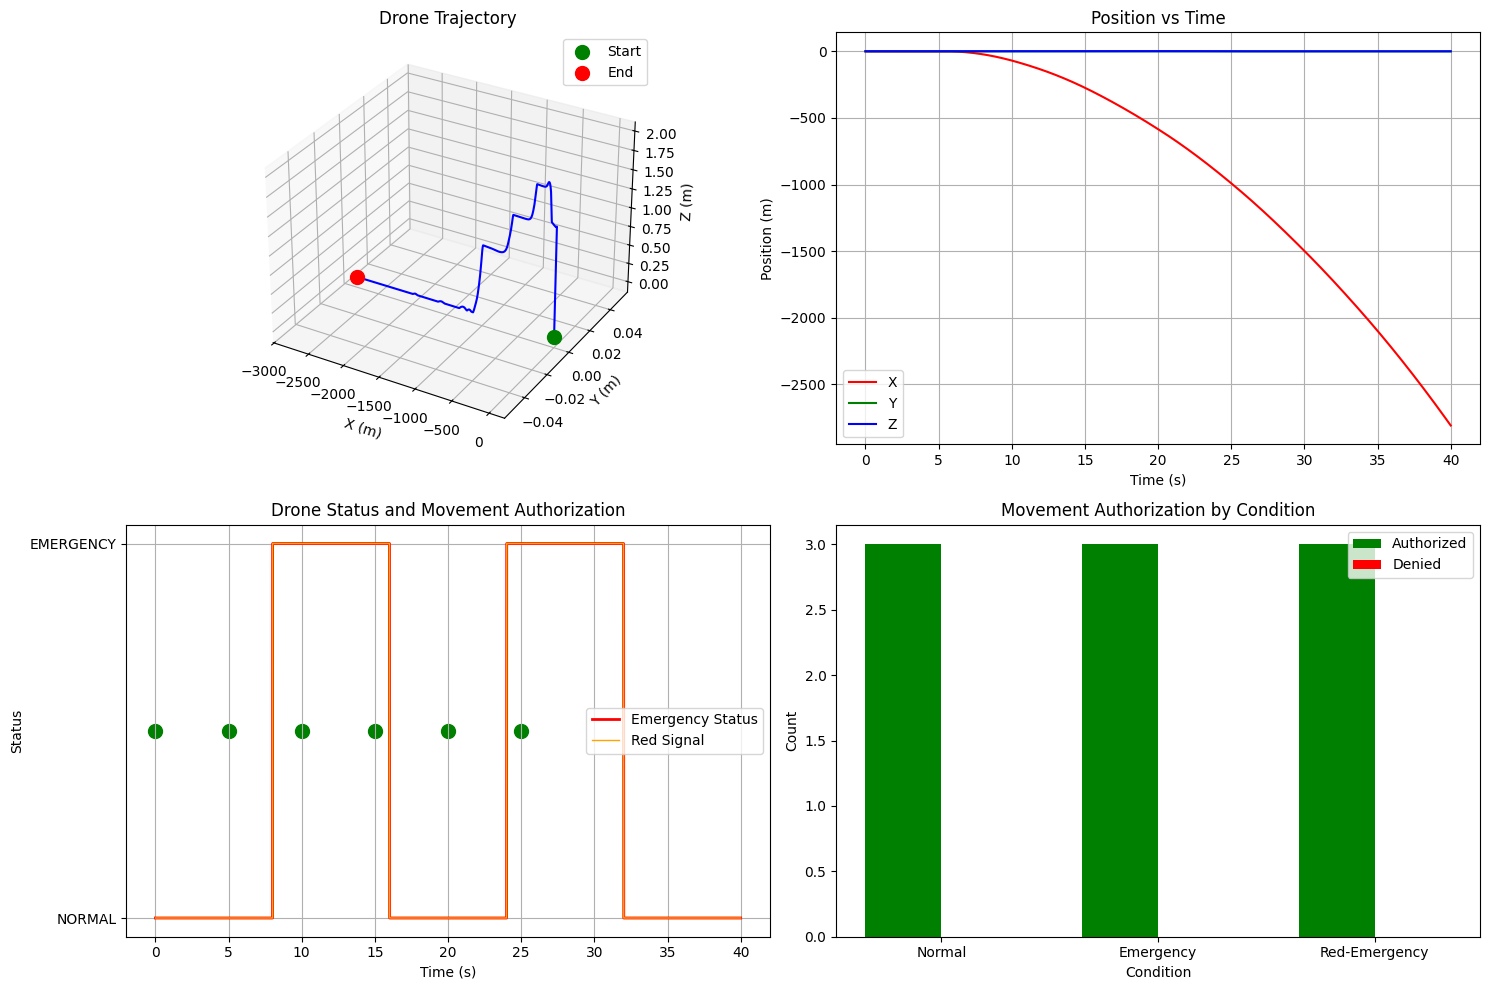


Simulating drone with MEDIUM uncertainty, NORMAL preferences...

Step 0: Setting drone status to NORMAL
Step 0: Attempting to go to waypoint 1: [0, 0, 1]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED
Step 500: Attempting to go to waypoint 2: [1, 0, 1.5]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED

Step 800: Setting drone status to EMERGENCY
Step 1000: Attempting to go to waypoint 3: [1, 1, 2]
  Status: EMERGENCY, Signal: RED
  Authorization: GRANTED
Status: EMERGENCY, Signal: RED
Step 1500: Attempting to go to waypoint 4: [0, 1, 1.5]
  Status: EMERGENCY, Signal: RED
  Authorization: DENIED

Step 1600: Setting drone status to NORMAL
Step 2000: Attempting to go to waypoint 4: [0, 1, 1.5]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED

Step 2400: Setting drone status to EMERGENCY
Status: EMERGENCY, Signal: RED
Step 2500: Attempting to go to waypoint 5: [0, 0, 1]
  Status: EMERGENCY, Signal: RED
  Authorization: DENIED
Status: EMERGENCY, Signal: RED
Step 

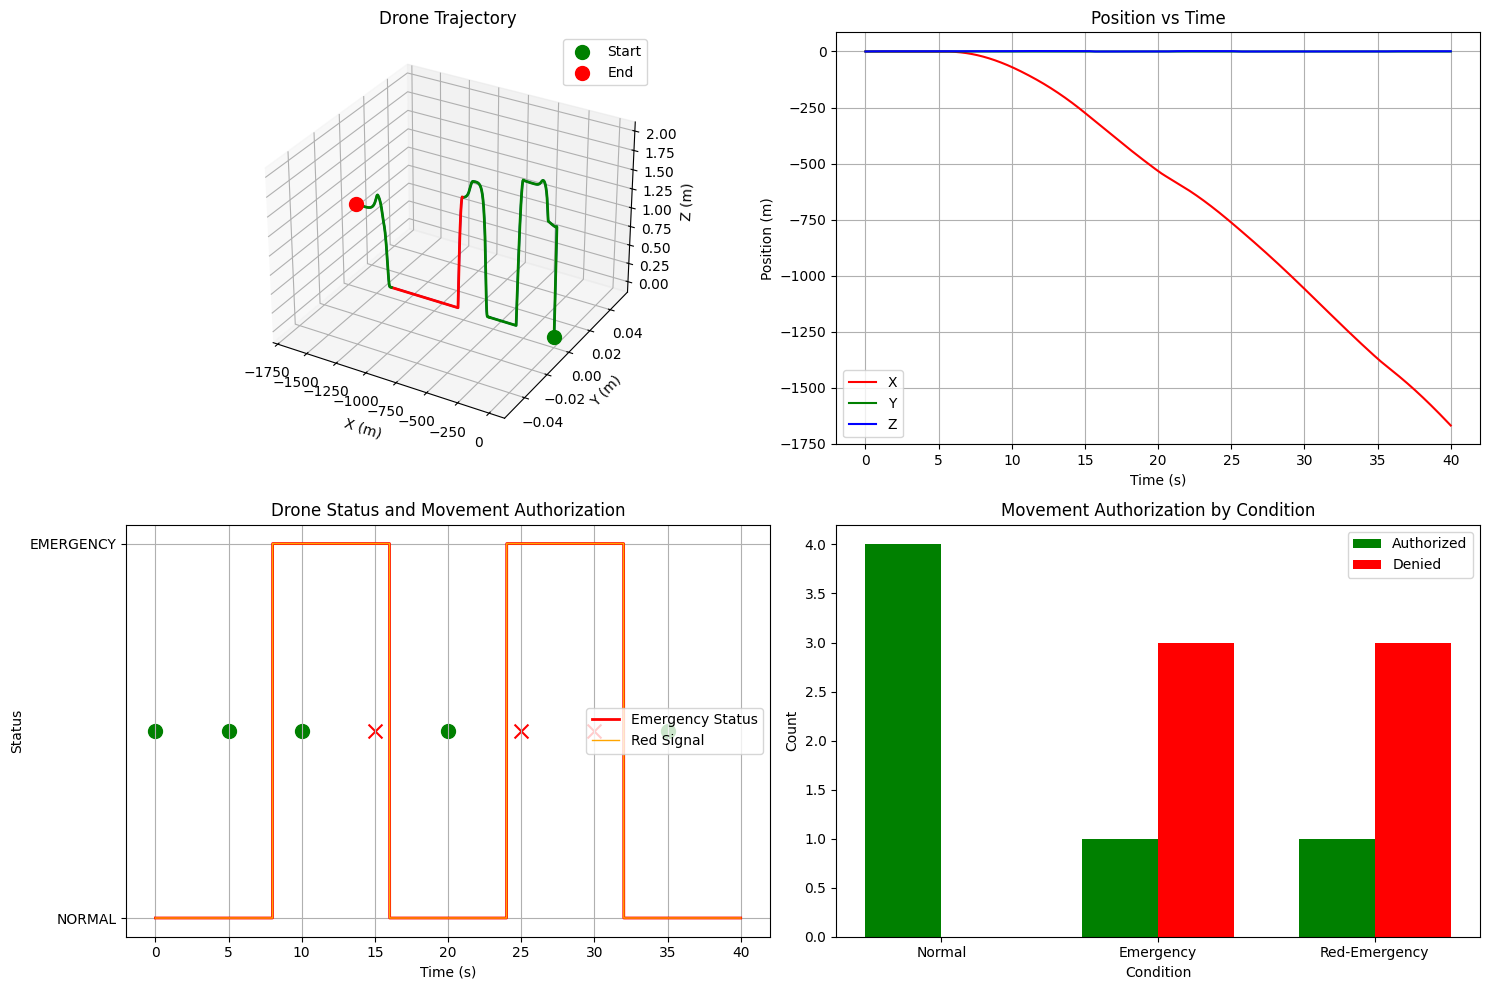


Simulating drone with HIGH uncertainty, STRONG preferences...

Step 0: Setting drone status to NORMAL
Step 0: Attempting to go to waypoint 1: [0, 0, 1]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED
Step 500: Attempting to go to waypoint 2: [1, 0, 1.5]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED

Step 800: Setting drone status to EMERGENCY
Status: EMERGENCY, Signal: RED
Step 1000: Attempting to go to waypoint 3: [1, 1, 2]
  Status: EMERGENCY, Signal: RED
  Authorization: DENIED
Status: EMERGENCY, Signal: RED
Step 1500: Attempting to go to waypoint 3: [1, 1, 2]
  Status: EMERGENCY, Signal: RED
  Authorization: DENIED

Step 1600: Setting drone status to NORMAL
Step 2000: Attempting to go to waypoint 3: [1, 1, 2]
  Status: NORMAL, Signal: GREEN
  Authorization: GRANTED

Step 2400: Setting drone status to EMERGENCY
Step 2500: Attempting to go to waypoint 4: [0, 1, 1.5]
  Status: EMERGENCY, Signal: RED
  Authorization: GRANTED
Step 3000: Attempting to go to waypoint 

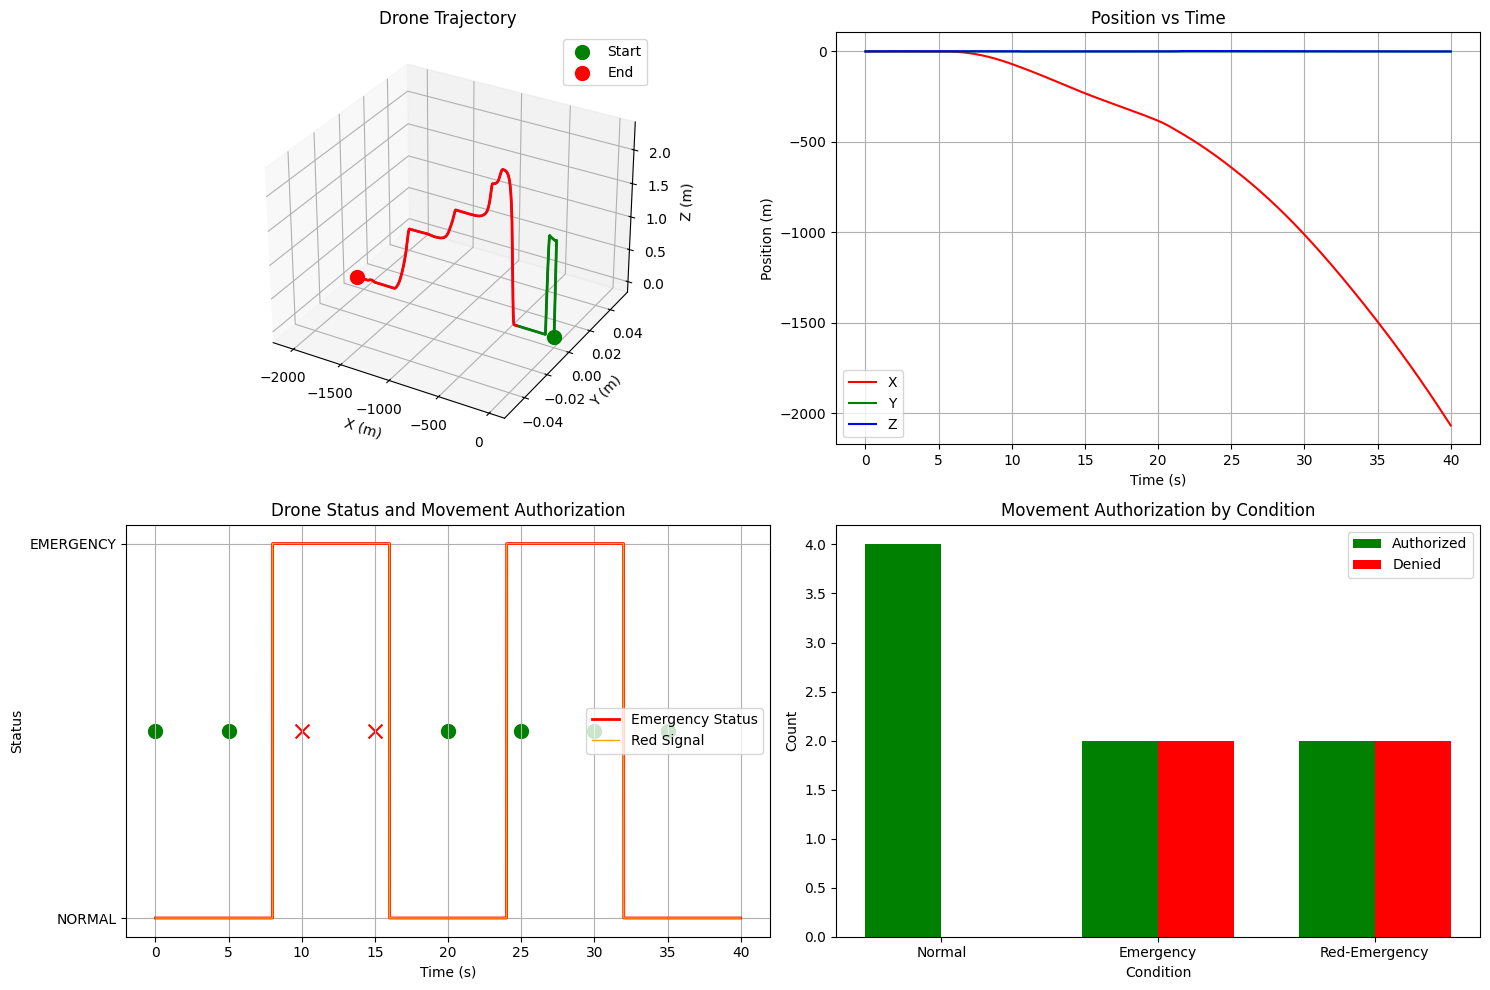

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
# from active_inference_fixed import enhanced_active_inference_model, spm_MDP_VB_X

class DroneModel:
    """Physical drone model that simulates the dynamics of a quadcopter."""

    def __init__(self):
        # Drone physical parameters
        self.mass = 1.0  # kg
        self.gravity = 9.81  # m/s^2
        self.I = np.array([0.01, 0.01, 0.02])  # Inertia moments (kg*m^2)
        self.arm_length = 0.2  # m

        # State variables
        self.position = np.zeros(3)  # [x, y, z] in m
        self.velocity = np.zeros(3)  # [vx, vy, vz] in m/s
        self.orientation = np.zeros(3)  # [roll, pitch, yaw] in radians
        self.angular_velocity = np.zeros(3)  # [wx, wy, wz] in rad/s

        # Control inputs (normalized between 0 and 1)
        self.motor_speeds = np.array([0.0, 0.0, 0.0, 0.0])

        # Simulation parameters
        self.dt = 0.01  # time step for integration

        # Motor constants
        self.thrust_coefficient = 5.0  # N/unit
        self.torque_coefficient = 0.05  # Nm/unit

        # History for plotting
        self.history = {
            'position': [self.position.copy()],
            'orientation': [self.orientation.copy()],
            'time': [0.0],
            'signal_color': ['GREEN'],
            'status': ['NORMAL'],
            'authorization': [True]
        }
        self.current_time = 0.0

        # Status variables
        self.status = "NORMAL"  # Can be NORMAL or EMERGENCY
        self.signal_color = "GREEN"  # Can be GREEN or RED

    def update(self, motor_speeds):
        """Update drone state based on motor inputs."""
        self.motor_speeds = np.clip(motor_speeds, 0.0, 1.0)

        # Calculate total thrust and torques
        thrust = self.thrust_coefficient * np.sum(self.motor_speeds)

        # Torque calculation (simplified model)
        # For a quadcopter in X configuration
        # Motors 0 and 2 rotate CW, Motors 1 and 3 rotate CCW
        roll_torque = self.arm_length * self.thrust_coefficient * (
            self.motor_speeds[1] + self.motor_speeds[2] -
            self.motor_speeds[0] - self.motor_speeds[3]
        )

        pitch_torque = self.arm_length * self.thrust_coefficient * (
            self.motor_speeds[0] + self.motor_speeds[1] -
            self.motor_speeds[2] - self.motor_speeds[3]
        )

        yaw_torque = self.torque_coefficient * (
            -self.motor_speeds[0] + self.motor_speeds[1] -
            self.motor_speeds[2] + self.motor_speeds[3]
        )

        torques = np.array([roll_torque, pitch_torque, yaw_torque])

        # Calculate acceleration
        # Rotation matrix (simplified)
        cos_roll, sin_roll = np.cos(self.orientation[0]), np.sin(self.orientation[0])
        cos_pitch, sin_pitch = np.cos(self.orientation[1]), np.sin(self.orientation[1])

        R = np.array([
            [cos_pitch, 0, -sin_pitch],
            [0, cos_roll, 0],
            [sin_pitch, 0, cos_pitch]
        ])

        # Force in global frame
        force_body = np.array([0, 0, thrust])
        force_global = R @ force_body

        # Acceleration = Force/mass + gravity
        acceleration = force_global / self.mass
        acceleration[2] -= self.gravity  # Gravity acts in negative z

        # Update position and velocity
        self.velocity += acceleration * self.dt
        self.position += self.velocity * self.dt

        # Prevent drone from going underground
        if self.position[2] < 0:
            self.position[2] = 0
            self.velocity[2] = 0

        # Update angular velocity and orientation
        angular_acceleration = torques / self.I
        self.angular_velocity += angular_acceleration * self.dt
        self.orientation += self.angular_velocity * self.dt

        # Normalize angles to [-pi, pi]
        self.orientation = np.mod(self.orientation + np.pi, 2 * np.pi) - np.pi

        # Update time and history
        self.current_time += self.dt
        self.history['position'].append(self.position.copy())
        self.history['orientation'].append(self.orientation.copy())
        self.history['time'].append(self.current_time)
        self.history['signal_color'].append(self.signal_color)
        self.history['status'].append(self.status)

    def set_emergency_status(self, is_emergency):
        """Set the emergency status of the drone."""
        self.status = "EMERGENCY" if is_emergency else "NORMAL"
        self.signal_color = "RED" if is_emergency else "GREEN"

    def get_state_indices(self):
        """Return the current state indices for active inference."""
        context_idx = 2 if self.signal_color == "RED" else 1
        condition_idx = 2 if self.status == "EMERGENCY" else 1
        return context_idx, condition_idx


class PIDController:
    """PID controller for drone position control."""

    def __init__(self, kp, ki, kd, output_limits=None):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.output_limits = output_limits

        self.integral = 0
        self.previous_error = 0
        self.first_run = True

    def update(self, error, dt):
        # Initialize previous error on first run
        if self.first_run:
            self.previous_error = error
            self.first_run = False

        # Proportional term
        p_term = self.kp * error

        # Integral term
        self.integral += error * dt
        i_term = self.ki * self.integral

        # Derivative term
        d_term = self.kd * (error - self.previous_error) / dt
        self.previous_error = error

        # Calculate output
        output = p_term + i_term + d_term

        # Apply limits if specified
        if self.output_limits is not None:
            output = np.clip(output, *self.output_limits)

        return output


class ActiveInferenceLayer:
    """
    Active Inference layer for normative decision-making for a drone.
    This layer decides whether the drone should move or not based on contextual information.
    """
    def __init__(self, uncertainty_level=0.5, add_preference=True, strong_preference=False):
        """
        Initialize the active inference layer.

        Parameters:
        uncertainty_level (float): Level of uncertainty in the model (0-1)
        add_preference (bool): Whether to prefer the 'off' state in emergency conditions
        strong_preference (bool): Whether to apply strong preference
        """
        self.mdp = enhanced_active_inference_model(
            uncertainty_level,
            add_preference,
            strong_preference
        )
        self.uncertainty_level = uncertainty_level
        self.add_preference = add_preference
        self.strong_preference = strong_preference

        # Mapping between discrete locations and continuous space
        self.location_mappings = [
            [0, 0, 0],  # Location 1
            [0, 0, 1],  # Location 2
            [1, 0, 1],  # Location 3
            [1, 0, 0],  # Location 4
            [0, 1, 0],  # Location 5
            [0, 1, 1],  # Location 6
            [1, 1, 1],  # Location 7
            [1, 1, 0]   # Location 8
        ]

        # Keep track of decisions
        self.decision_history = []

    def position_to_location_index(self, position):
        """Convert continuous position to discrete location index (1-8)."""
        position = np.array(position)
        # Discretize position to binary values
        binary_pos = np.round(position).astype(int)
        binary_pos = np.clip(binary_pos, 0, 1)  # Ensure values are 0 or 1

        # Find the matching location
        for i, mapping in enumerate(self.location_mappings):
            if np.array_equal(binary_pos, mapping):
                return i + 1  # 1-indexed

        # If no exact match, find closest
        distances = [np.sum((binary_pos - np.array(m))**2) for m in self.location_mappings]
        closest_idx = np.argmin(distances)
        return closest_idx + 1  # 1-indexed

    def query(self, position, context_idx, condition_idx):
        """
        Query the active inference model for a decision about movement authorization.

        Parameters:
        position: 3D position array [x, y, z]
        context_idx: Context index (1=Green, 2=Red)
        condition_idx: Condition index (1=Normal, 2=Emergency)

        Returns:
        bool: True if movement is authorized, False if not
        """
        # Convert position to location index
        location_idx = self.position_to_location_index(position)

        # Set up the query
        self.mdp['s'] = {}
        self.mdp['s'][1] = np.array([[location_idx]])  # Position
        self.mdp['s'][2] = np.array([[context_idx]])   # Context
        self.mdp['s'][3] = np.array([[condition_idx]]) # Condition

        # Run active inference
        result = spm_MDP_VB_X(self.mdp)

        # Get the actuator state (1=ON/authorized, 2=OFF/not authorized)
        if 1 in result['o'] and result['o'][1].shape[0] > 0:
            actuator_state = result['o'][1][-1, 0]
        else:
            # Default to ON if there's an issue
            actuator_state = 1

        # Record the decision
        decision = {
            'position': position,
            'location_idx': location_idx,
            'context_idx': context_idx,
            'condition_idx': condition_idx,
            'actuator_state': actuator_state,
            'authorized': actuator_state == 1
        }
        self.decision_history.append(decision)

        # Return authorization (1=ON/authorized, 2=OFF/not authorized)
        return actuator_state == 1


class NormativeDroneController:
    """
    Enhanced drone controller that uses active inference for normative decision-making.
    """
    def __init__(self, drone_model, uncertainty_level=0.5, strong_preference=False):
        self.drone = drone_model

        # PID controllers for position
        self.pid_x = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
        self.pid_y = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
        self.pid_z = PIDController(2.0, 0.1, 1.0, output_limits=(-1.0, 1.0))

        # PID controllers for angles
        self.pid_roll = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
        self.pid_pitch = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
        self.pid_yaw = PIDController(3.0, 0.0, 1.0, output_limits=(-0.3, 0.3))

        # Target positions and orientations
        self.target_position = np.zeros(3)
        self.target_yaw = 0.0

        # Active inference normative layer
        self.active_inference = ActiveInferenceLayer(
            uncertainty_level=uncertainty_level,
            add_preference=True,
            strong_preference=strong_preference
        )
        self.use_active_inference = True

        # Travel authorization flag
        self.travel_authorized = True

        # Tracking variables
        self.unauthorized_attempts = 0
        self.authorized_movements = 0
        self.movement_history = []

    def set_target(self, position, yaw=0.0):
        """Set target position and yaw orientation, checking if movement is authorized."""
        # Get the current signal status
        context_idx, condition_idx = self.drone.get_state_indices()

        # Record this movement attempt
        movement_attempt = {
            'timestamp': self.drone.current_time,
            'current_position': self.drone.position.copy(),
            'target_position': np.array(position),
            'context': 'RED' if context_idx == 2 else 'GREEN',
            'condition': 'EMERGENCY' if condition_idx == 2 else 'NORMAL'
        }

        # Check with active inference if movement is allowed
        if self.use_active_inference:
            # Query active inference layer
            self.travel_authorized = self.active_inference.query(
                position, context_idx, condition_idx
            )

            movement_attempt['authorized'] = self.travel_authorized

            if not self.travel_authorized:
                print(f"WARNING: Travel to {position} NOT AUTHORIZED!")
                print(f"Status: {self.drone.status}, Signal: {self.drone.signal_color}")
                self.unauthorized_attempts += 1
                self.movement_history.append(movement_attempt)
                return False
            else:
                self.authorized_movements += 1
        else:
            # If not using active inference, always authorize
            self.travel_authorized = True
            movement_attempt['authorized'] = True

        # If authorized or not using active inference, set the target
        self.target_position = np.array(position)
        self.target_yaw = yaw

        # Add to history
        self.movement_history.append(movement_attempt)

        return True

    def update(self):
        """Calculate control inputs based on current state and targets."""
        if not self.travel_authorized:
            # If movement is not authorized, hold position (zero thrust)
            return np.array([0.1, 0.1, 0.1, 0.1])  # Minimal thrust to hover

        # Position errors
        pos_error = self.target_position - self.drone.position

        # Desired roll and pitch based on position error
        desired_pitch = self.pid_x.update(pos_error[0], self.drone.dt)
        desired_roll = -self.pid_y.update(pos_error[1], self.drone.dt)  # Negative for correct mapping

        # Altitude control
        z_thrust = 0.5 + self.pid_z.update(pos_error[2], self.drone.dt)  # Base thrust plus correction

        # Angle errors
        roll_error = desired_roll - self.drone.orientation[0]
        pitch_error = desired_pitch - self.drone.orientation[1]
        yaw_error = self.target_yaw - self.drone.orientation[2]

        # Normalize yaw error to [-pi, pi]
        yaw_error = np.mod(yaw_error + np.pi, 2 * np.pi) - np.pi

        # Calculate torque corrections
        roll_correction = self.pid_roll.update(roll_error, self.drone.dt)
        pitch_correction = self.pid_pitch.update(pitch_error, self.drone.dt)
        yaw_correction = self.pid_yaw.update(yaw_error, self.drone.dt)

        # Calculate motor speeds
        # For a quadcopter in X configuration:
        # m0: front-right, m1: front-left, m2: back-left, m3: back-right
        m0 = z_thrust - roll_correction + pitch_correction - yaw_correction
        m1 = z_thrust + roll_correction + pitch_correction + yaw_correction
        m2 = z_thrust + roll_correction - pitch_correction - yaw_correction
        m3 = z_thrust - roll_correction - pitch_correction + yaw_correction

        # Ensure motor values are within limits
        motor_speeds = np.clip(np.array([m0, m1, m2, m3]), 0.0, 1.0)

        return motor_speeds


def simulate_normative_drone(uncertainty_level=0.5, strong_preference=False, plot_results=True):
    """
    Simulate a drone with active inference normative control.

    Parameters:
    uncertainty_level : float
        The level of uncertainty in the active inference model (0-1)
    strong_preference : bool
        Whether to use strong preferences in the active inference model
    plot_results : bool
        Whether to plot the simulation results
    """
    # Create drone and controller
    drone = DroneModel()
    controller = NormativeDroneController(
        drone,
        uncertainty_level=uncertainty_level,
        strong_preference=strong_preference
    )

    # Define waypoints
    waypoints = [
        [0, 0, 1],     # Take off to 1m
        [1, 0, 1.5],   # Move forward and up slightly
        [1, 1, 2],     # Move right and up
        [0, 1, 1.5],   # Move backward
        [0, 0, 1],     # Return to start position
        [0, 0, 0]      # Land
    ]

    # Simulation parameters
    total_steps = 4000
    waypoint_interval = 500  # Steps between waypoint changes
    status_interval = 800    # Steps between status changes

    # Main simulation loop
    current_waypoint = 0
    for step in range(total_steps):
        # Change status periodically to test emergency scenarios
        if step % status_interval == 0:
            is_emergency = (step // status_interval) % 2 == 1
            drone.set_emergency_status(is_emergency)
            print(f"\nStep {step}: Setting drone status to {'EMERGENCY' if is_emergency else 'NORMAL'}")

        # Try to go to a new waypoint periodically
        if step % waypoint_interval == 0 and current_waypoint < len(waypoints):
            target = waypoints[current_waypoint]
            authorized = controller.set_target(target)

            print(f"Step {step}: Attempting to go to waypoint {current_waypoint+1}: {target}")
            print(f"  Status: {drone.status}, Signal: {drone.signal_color}")
            print(f"  Authorization: {'GRANTED' if authorized else 'DENIED'}")

            if authorized:
                current_waypoint += 1

        # Update control and drone state
        motor_speeds = controller.update()
        drone.update(motor_speeds)

    # Print summary
    print("\nSimulation Summary:")
    print(f"Total movement attempts: {len(controller.movement_history)}")
    authorized_count = sum(1 for m in controller.movement_history if m['authorized'])
    denied_count = len(controller.movement_history) - authorized_count
    print(f"Authorized movements: {authorized_count}")
    print(f"Denied movements: {denied_count}")

    # Count by condition
    normal_attempts = sum(1 for m in controller.movement_history if m['condition'] == 'NORMAL')
    normal_authorized = sum(1 for m in controller.movement_history
                       if m['condition'] == 'NORMAL' and m['authorized'])
    emergency_attempts = sum(1 for m in controller.movement_history if m['condition'] == 'EMERGENCY')
    emergency_authorized = sum(1 for m in controller.movement_history
                         if m['condition'] == 'EMERGENCY' and m['authorized'])

    if normal_attempts > 0:
        print(f"\nNormal condition: {normal_authorized}/{normal_attempts} authorized " +
              f"({normal_authorized/normal_attempts*100:.1f}%)")
    else:
        print(f"\nNormal condition: {normal_authorized}/{normal_attempts} authorized (N/A%)")

    if emergency_attempts > 0:
        print(f"Emergency condition: {emergency_authorized}/{emergency_attempts} authorized " +
              f"({emergency_authorized/emergency_attempts*100:.1f}%)")

    red_emergency_attempts = sum(1 for m in controller.movement_history
                            if m['condition'] == 'EMERGENCY' and m['context'] == 'RED')
    red_emergency_authorized = sum(1 for m in controller.movement_history
                             if m['condition'] == 'EMERGENCY' and m['context'] == 'RED' and m['authorized'])

    if red_emergency_attempts > 0:
        print(f"Red-Emergency condition: {red_emergency_authorized}/{red_emergency_attempts} authorized " +
              f"({red_emergency_authorized/red_emergency_attempts*100:.1f}%)")

    # Plot results
    if plot_results:
        plot_drone_simulation(drone, controller)

    return drone, controller


def plot_drone_simulation(drone, controller):
    """Plot the results of the drone simulation."""
    # Create figure
    plt.figure(figsize=(15, 10))

    # Plot 3D trajectory
    ax1 = plt.subplot(221, projection='3d')
    positions = np.array(drone.history['position'])
    ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-')
    ax1.scatter(positions[0, 0], positions[0, 1], positions[0, 2], c='g', marker='o', s=100, label='Start')
    ax1.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], c='r', marker='o', s=100, label='End')

    # Color segments by authorization
    auth_changes = []
    for i in range(1, len(controller.movement_history)):
        if controller.movement_history[i]['authorized'] != controller.movement_history[i-1]['authorized']:
            idx = int(controller.movement_history[i]['timestamp'] / drone.dt)
            auth_changes.append(idx)

    if auth_changes:
        for i in range(len(auth_changes) + 1):
            start_idx = 0 if i == 0 else auth_changes[i-1]
            end_idx = len(positions) if i == len(auth_changes) else auth_changes[i]

            # Color based on authorization
            is_authorized = controller.movement_history[min(i, len(controller.movement_history)-1)]['authorized']
            color = 'g' if is_authorized else 'r'

            # Plot this segment
            ax1.plot(positions[start_idx:end_idx, 0],
                    positions[start_idx:end_idx, 1],
                    positions[start_idx:end_idx, 2],
                    color=color, linewidth=2)

    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('Drone Trajectory')
    ax1.legend()

    # Plot position vs time
    ax2 = plt.subplot(222)
    time = drone.history['time']
    ax2.plot(time, positions[:, 0], 'r-', label='X')
    ax2.plot(time, positions[:, 1], 'g-', label='Y')
    ax2.plot(time, positions[:, 2], 'b-', label='Z')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Position (m)')
    ax2.set_title('Position vs Time')
    ax2.legend()
    ax2.grid(True)

    # Plot status timeline
    ax3 = plt.subplot(223)
    status_values = [1 if s == 'EMERGENCY' else 0 for s in drone.history['status']]
    color_values = [1 if c == 'RED' else 0 for c in drone.history['signal_color']]

    ax3.plot(time, status_values, 'r-', linewidth=2, label='Emergency Status')
    ax3.plot(time, color_values, 'orange', linewidth=1, label='Red Signal')

    # Add movement events
    for i, movement in enumerate(controller.movement_history):
        t = movement['timestamp']
        authorized = movement['authorized']
        marker = 'o' if authorized else 'x'
        color = 'g' if authorized else 'r'
        ax3.scatter(t, 0.5, marker=marker, color=color, s=100)

    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Status')
    ax3.set_yticks([0, 1])
    ax3.set_yticklabels(['NORMAL', 'EMERGENCY'])
    ax3.set_title('Drone Status and Movement Authorization')
    ax3.legend()
    ax3.grid(True)

    # Plot authorization summary
    ax4 = plt.subplot(224)

    # Organize data by condition
    categories = ['Normal', 'Emergency', 'Red-Emergency']

    # Count authorization success by category
    normal_success = sum(1 for m in controller.movement_history
                       if m['condition'] == 'NORMAL' and m['authorized'])
    normal_fail = sum(1 for m in controller.movement_history
                    if m['condition'] == 'NORMAL' and not m['authorized'])

    emergency_success = sum(1 for m in controller.movement_history
                        if m['condition'] == 'EMERGENCY' and m['authorized'])
    emergency_fail = sum(1 for m in controller.movement_history
                      if m['condition'] == 'EMERGENCY' and not m['authorized'])

    red_emergency_success = sum(1 for m in controller.movement_history
                            if m['condition'] == 'EMERGENCY' and m['context'] == 'RED' and m['authorized'])
    red_emergency_fail = sum(1 for m in controller.movement_history
                          if m['condition'] == 'EMERGENCY' and m['context'] == 'RED' and not m['authorized'])

    success_counts = [normal_success, emergency_success, red_emergency_success]
    fail_counts = [normal_fail, emergency_fail, red_emergency_fail]

    # Set up bar positions
    bar_width = 0.35
    bar_positions = np.arange(len(categories))

    # Create bars
    ax4.bar(bar_positions - bar_width/2, success_counts, bar_width, label='Authorized', color='g')
    ax4.bar(bar_positions + bar_width/2, fail_counts, bar_width, label='Denied', color='r')

    # Customize bar chart
    ax4.set_xlabel('Condition')
    ax4.set_ylabel('Count')
    ax4.set_title('Movement Authorization by Condition')
    ax4.set_xticks(bar_positions)
    ax4.set_xticklabels(categories)
    ax4.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("Simulating drone with NO uncertainty, NO preferences...")
    drone1, controller1 = simulate_normative_drone(uncertainty_level=0, strong_preference=False)

    print("\nSimulating drone with MEDIUM uncertainty, NORMAL preferences...")
    drone2, controller2 = simulate_normative_drone(uncertainty_level=0.5, strong_preference=False)

    print("\nSimulating drone with HIGH uncertainty, STRONG preferences...")
    drone3, controller3 = simulate_normative_drone(uncertainty_level=0.8, strong_preference=True)